In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from time import time
from datetime import datetime
%matplotlib inline 

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 999)

plt.rcParams.update({'font.size': 22})

In [3]:
# "3.8 V 3000mAh Li-Po battery, which is 32832 joules"
# in "Comparison of LoRa and NB-IoT in Terms of Power Consumption"
# https://www.diva-portal.org/smash/get/diva2:1451892/FULLTEXT01.pdf

#BATTERY_BUDGET = 32832 # in Joules
BATTERY_BUDGET = 31752 # in Joules

In [4]:
# %%bash
# cd ..  
# cd .. 
# chmod +x script.sh
# ./script.sh

In [5]:
subtitles_basic = {
    1 : '1.000 m² de área monitorada',
    2 : 'Frequência de envio de 2 mensagens / h',
    3 : 'Implantação de nós em grade uniforme',
    4 : 'Tamanho de mensagem em 22 bytes',
    5 : 'Densidade de nós de 10 / 1.000 m²',
    6 : 'Adicionais de área',
    7 : 'Adicionais de densidade de nós'
}

In [6]:
subtitles = {
    'A1F1D1T1S1' : 'Cenário base',
    'A2F1D1T1S1' : '100.000 m² de área monitorada',
    'A1F2D1T1S1' : 'Frequência de envio de 10 mensagens / h',
    'A1F3D1T1S1' : 'Frequência de envio de 20 mensagens / h',
    'A1F1D2T1S1' : 'Implantação de nós aleatória',
    'A1F1D1T2S1' : 'Tamanho de mensagem em 64 bytes',
    'A1F1D1T3S1' : 'Tamanho de mensagem em 222 bytes',
    'A1F1D1T1S2' : 'Densidade de nós de 50 / 1.000 m²',
    'A1F1D1T1S3' : 'Densidade de nós de 100 / 1000 m²',
    'A3F1D1T1S1' : '5km x 5km de área monitorada, implantação em grade',
    'A3F1D2T1S1' : '5km x 5km de área monitorada, implantação aleatória',
    'A4F1D1T1S1' : '10km x 10km de área monitorada, implantação em grade',
    'A4F1D2T1S1' : '10km x 10km de área monitorada, implantação aleatória',
    'A1F1D1T1S4' : '1.000 nós, 1.000 m² de área monitorada, implantação em grade',
    'A1F1D2T1S4' : '1.000 nós, 1.000 m² de área monitorada, implantação aleatória',
    'A4F1D1T1S4' : '1.000 nós, 5km x 5km de área monitorada, implantação em grade', 
    'A4F1D2T1S4' : '1.000 nós, 5km x 5km de área monitorada, implantação aleatória'
    }

In [7]:
def get_path_list(log):
    
    log_path_list = []
    
    base_config = [log + 'A1F1D1T1S1']

    n_scenario = 1
    log_list = base_config + [log + 'A2F1D1T1S1']
    log_path_list += [str(f"scenario{n_scenario}/" + log) for log in log_list]

    n_scenario = 2
    log_list = base_config + [log + 'A1F2D1T1S1', log + 'A1F3D1T1S1']
    log_path_list += [str(f"scenario{n_scenario}/" + log) for log in log_list]

    n_scenario = 3
    log_list = base_config + [log + 'A1F1D2T1S1']
    log_path_list += [str(f"scenario{n_scenario}/" + log) for log in log_list]

    n_scenario = 4
    log_list = base_config + [log + 'A1F1D1T2S1', log + 'A1F1D1T3S1']
    log_path_list += [str(f"scenario{n_scenario}/" + log) for log in log_list]

    n_scenario = 5
    log_list = base_config + [log + 'A1F1D1T1S2', log + 'A1F1D1T1S3']
    log_path_list += [str(f"scenario{n_scenario}/" + log) for log in log_list]
    
    return log_path_list

In [8]:
num_lines = 31536026
num_lines/10.**4

3153.6026

In [9]:
def lines_to_df(lines):
    
#     now = datetime.now()
    
    time = []
    node = []
    packet = []
    
    columns = ['time', 'node', 'packet']

    for line in lines:
        line = line[0]
        if(line[0] != '+'):
            continue

        splitted = line.split()

        if(splitted[1] == '-1'):
            continue

        # Delete '+' and 's' from time
        t = float(splitted[0][1:-1].replace('+', '').replace('s', ''))
        n = int(splitted[1])
        p = int(splitted[2])

        #print(t, n, p)

        time.append(t)
        node.append(n)
        packet.append(p)

    
    temp = pd.DataFrame(list(zip(time, node, packet)), columns = columns)
    temp.time = temp.time.astype('float')
    temp.node = temp.node.astype('int')
    temp.packet = temp.packet.astype('int')
    
    temp_listed = temp.groupby(['packet']).agg({'node': list}).reset_index()
    
    # Filling dataframe of packets with sent/received messages list 'temp'
    columns = ['packet', 'sender', 'receiver']
    df = pd.DataFrame(list(zip(temp_listed['packet'], 
                               temp_listed['node'].apply(lambda node_list: node_list[0]), 
                               temp_listed['node'].apply(lambda node_list: node_list[1]))), 
                      columns = columns)
    
#     duration = (datetime.now() - now).total_seconds()
#     now = datetime.now()
#     current_time = now.strftime("%H:%M:%S")
#     print(f'{current_time} - {int(duration)}s')
    
    return df

In [10]:
def get_receiver(nodes_list):
    try:
        receiver = nodes_list[1]
    except:
        receiver = None
        
    return receiver

def lines_to_df(lines, to_csv=False):
    
    time = []
    node = []
    packet = []
    
    columns = ['time', 'node', 'packet']

    for line in lines:
        line = line[0]
        if(line[0] != '+'):
            continue

        splitted = line.split()

        if(splitted[1] == '-1'):
            continue

        # Delete '+' and 's' from time
        t = float(splitted[0][1:-1].replace('+', '').replace('s', ''))
        n = int(splitted[1])
        p = int(splitted[2])

        #print(t, n, p)

        time.append(t)
        node.append(n)
        packet.append(p)

    temp = pd.DataFrame(list(zip(time, node, packet)), columns = columns)
    temp.time = temp.time.astype('float')
    temp.node = temp.node.astype('int')
    temp.packet = temp.packet.astype('int')
    
    # Filling dataframe of packets with sent/received messages list 'temp'
    columns = ['time', 'packet', 'sender', 'receiver', 'latency']
    temp_listed = temp.groupby(['packet']).agg({'time' : list, 'node': list}).reset_index()

    time = temp_listed['time'].apply(lambda time_list: time_list[0])
    packet = temp_listed['packet']
    sender = temp_listed['node'].apply(lambda node_list: node_list[0])
    receiver = temp_listed['node'].apply(get_receiver).T.values
    latency = temp_listed['time'].apply(get_receiver).T.values - time

    df = pd.DataFrame(list(zip(time, packet, sender, receiver, latency)), columns = columns)

    if(to_csv):
        df.to_csv(f'{path}.csv', mode='w', index=False, header=False)
    
    return df

In [11]:
import csv
# -- Read log file and transform into Dataframe --

# Transform log lines into Pandas DataFrame accoding to the type of 'log'.
# Use the following inputs to load the correspondent 'log':
# 'bat' for battery log, with energy consumption
# 'der' for data extraction rate log


def process_chunk_remainder(df):
    if(len(df) == 0):
        return pd.DataFrame()
    gateway = int(df['receiver'].mean())
    packets = df[df['receiver'] != gateway]
    packets_listed = packets.groupby('packet').agg({'time' : list, 'sender': list}).reset_index()
    
    remainder = pd.DataFrame(list(), columns = df.columns)

    for index, packet_listed in packets_listed.iterrows():      
        time = packet_listed['time'][0]
        packet = packet_listed['packet']
        sender = packet_listed['sender'][0]

        if(len(packet_listed['sender']) < 2):
            receiver = None
            latency = None
        else:
            receiver = packet_listed['sender'][1]
            latency = packet_listed['time'][1] - time

        remainder.loc[len(remainder)] = {'time' : time, 
                                         'packet' : packet, 
                                         'sender' : sender, 
                                         'receiver' : receiver, 
                                         'latency' : latency}
    df = df[df['receiver'] == gateway]
    df = pd.concat([df, remainder]).sort_values('time').reset_index(drop=True)

    return df

def log_to_frame(log, to_csv=False):
    
    path = f'../log/{log}'
    reader = csv.reader(open(f'{path}.txt'))

    chunk, chunksize = [], 10.**4
    df_list = []

    for i, line in enumerate(reader):
        if (i % chunksize == 0 and i > 0):
            df_list.append(lines_to_df(chunk))
            del chunk[:]  # or: chunk = []

        chunk.append(line)

    # process the remainder of chunk division
    df_list.append(lines_to_df(chunk))
    
    df = pd.concat([df for df in df_list])
    df = process_chunk_remainder(df)

    return df

In [12]:
log = 'der'
log_path_list = get_path_list(log)
print(log_path_list)
len(log_path_list)

['scenario1/derA1F1D1T1S1', 'scenario1/derA2F1D1T1S1', 'scenario2/derA1F1D1T1S1', 'scenario2/derA1F2D1T1S1', 'scenario2/derA1F3D1T1S1', 'scenario3/derA1F1D1T1S1', 'scenario3/derA1F1D2T1S1', 'scenario4/derA1F1D1T1S1', 'scenario4/derA1F1D1T2S1', 'scenario4/derA1F1D1T3S1', 'scenario5/derA1F1D1T1S1', 'scenario5/derA1F1D1T1S2', 'scenario5/derA1F1D1T1S3']


13

In [22]:
%%time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f"{current_time}")

for log_path in log_path_list:
    scenario_config = log_path[-10:]
    scenario_number = log_path[8]
    
    now = datetime.now()
    
    df = log_to_frame(log_path)
    print()
    der = (~df['receiver'].isna()).sum() / df['sender'].count()
    print(f'Cenário {scenario_number} - {scenario_config} - DER = {der}')
    
    duration = (datetime.now() - now).total_seconds()
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(f'{current_time} - {int(duration)}s')

14:03:42

Cenário 1 - A1F1D1T1S1 - DER = 1.0
14:03:42 - 0s

Cenário 2 - A1F1D1T1S1 - DER = 1.0
14:03:43 - 0s

Cenário 2 - A1F2D1T1S1 - DER = 1.0
14:03:43 - 0s

Cenário 2 - A1F3D1T1S1 - DER = 1.0
14:03:43 - 0s

Cenário 3 - A1F1D1T1S1 - DER = 1.0
14:03:44 - 0s

Cenário 3 - A1F1D2T1S1 - DER = 1.0
14:03:44 - 0s

Cenário 4 - A1F1D1T1S1 - DER = 1.0
14:03:44 - 0s

Cenário 4 - A1F1D1T2S1 - DER = 1.0
14:03:44 - 0s

Cenário 4 - A1F1D1T3S1 - DER = 1.0
14:03:44 - 0s

Cenário 5 - A1F1D1T1S1 - DER = 1.0
14:03:45 - 0s

Cenário 5 - A1F1D1T1S2 - DER = 1.0
14:03:46 - 1s

Cenário 5 - A1F1D1T1S3 - DER = 1.0
14:03:49 - 2s
CPU times: user 6.87 s, sys: 18.6 ms, total: 6.88 s
Wall time: 6.87 s


66.81605652307516
66.81605809662958
66.8160725666443
66.81606355548094
66.81606355808209
66.81655286225501
66.8160635649688


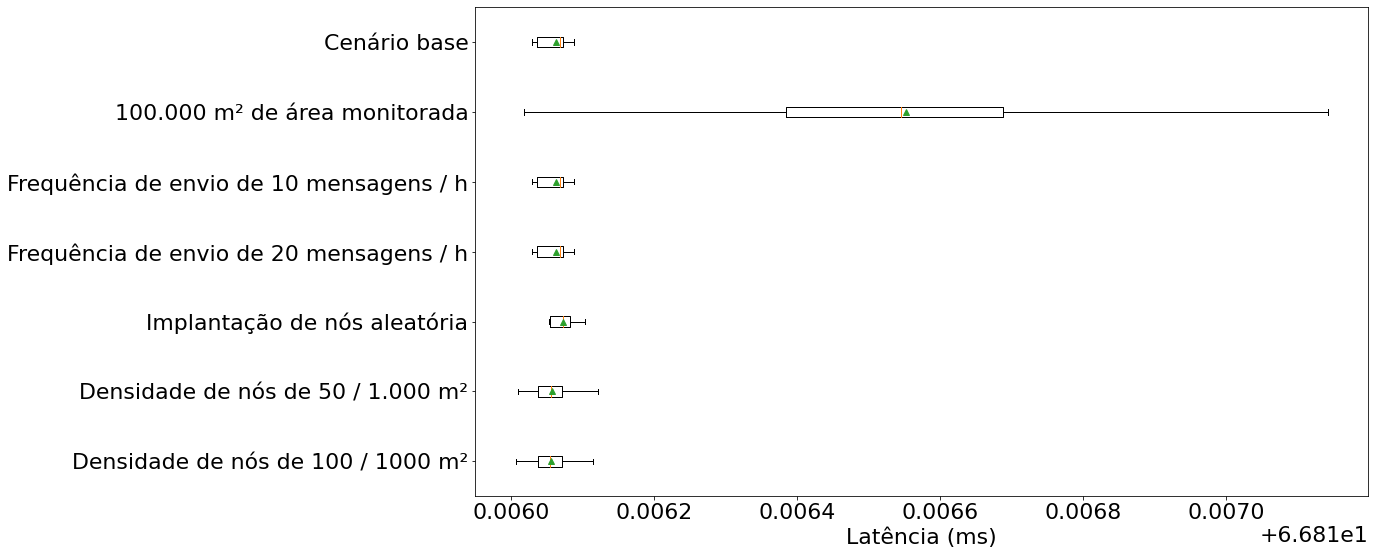

CPU times: user 43.2 s, sys: 27.8 ms, total: 43.2 s
Wall time: 43.2 s


In [305]:
%%time

subtitles = {
    'A1F1D1T1S1' : 'Cenário base',
    'A2F1D1T1S1' : '100.000 m² de área monitorada',
    'A1F2D1T1S1' : 'Frequência de envio de 10 mensagens / h',
    'A1F3D1T1S1' : 'Frequência de envio de 20 mensagens / h',
    'A1F1D2T1S1' : 'Implantação de nós aleatória',
    'A1F1D1T1S2' : 'Densidade de nós de 50 / 1.000 m²',
    'A1F1D1T1S3' : 'Densidade de nós de 100 / 1000 m²'
    }

log_path_list = ['scenario1/derA1F1D1T1S1',
                 'scenario1/derA2F1D1T1S1',
                 'scenario2/derA1F2D1T1S1',
                 'scenario2/derA1F3D1T1S1',
                 'scenario3/derA1F1D2T1S1',
                 'scenario5/derA1F1D1T1S2',
                 'scenario5/derA1F1D1T1S3']
log_path_list.reverse()

latency = pd.DataFrame()
for num_log_path, log_path in enumerate(log_path_list):
    scenario_config = log_path[-10:]
    scenario_number = int(log_path[8])
    
    df = log_to_frame(log_path)
    df['latency'] = df['latency'] * 1000
    subtitle = subtitles[scenario_config]
    latency[subtitle] = df['latency']
    
    print(df['latency'].mean())
    
fig, ax = plt.subplots(figsize=(16,9))

bp = []
for pos, col in enumerate(latency):
    bp.append(ax.boxplot(latency[col].dropna(), positions=[pos], showmeans=True, vert=False, showfliers=False))
    
ax.set_xlabel('Latência (ms)')
#ax.set_ylabel('Configurações')
ax.set_yticklabels(latency.columns.values, rotation='horizontal')

plt.savefig('lat1-4_5.jpg')
plt.show()

363.7760635524014
133.3760635535626
66.8160635649688


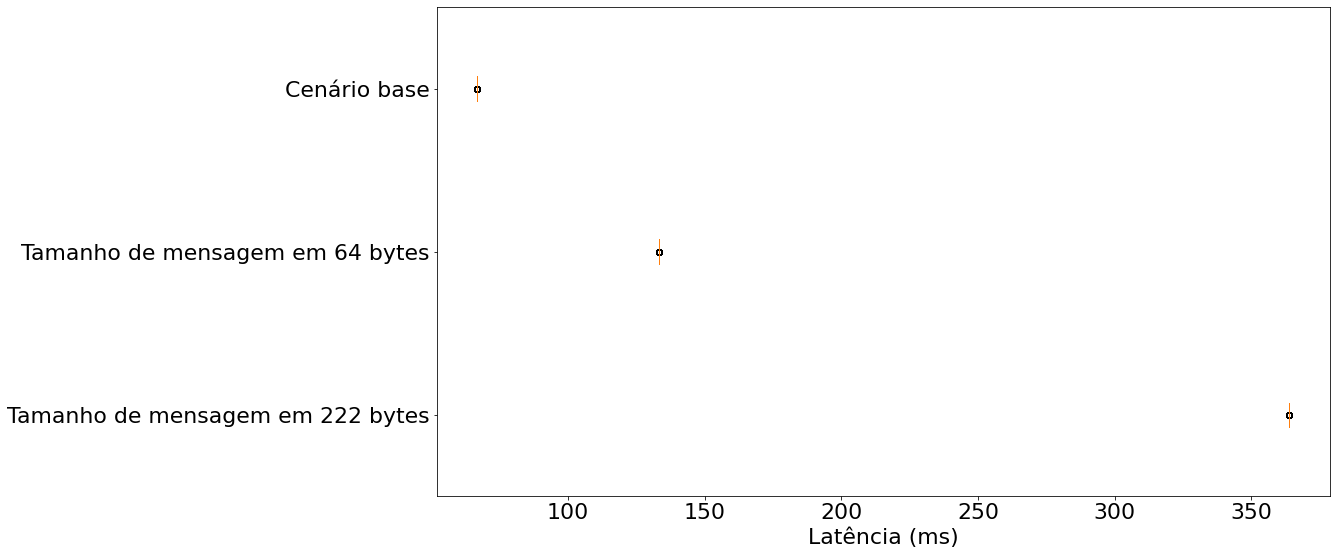

CPU times: user 656 ms, sys: 0 ns, total: 656 ms
Wall time: 656 ms


In [290]:
%%time

subtitles = {
    'A1F1D1T1S1' : 'Cenário base',
    'A1F1D1T2S1' : 'Tamanho de mensagem em 64 bytes',
    'A1F1D1T3S1' : 'Tamanho de mensagem em 222 bytes'
    }

log_path_list = ['scenario4/derA1F1D1T1S1',
                 'scenario4/derA1F1D1T2S1',
                 'scenario4/derA1F1D1T3S1']
log_path_list.reverse()

latency = pd.DataFrame()
for num_log_path, log_path in enumerate(log_path_list):
    scenario_config = log_path[-10:]
    scenario_number = int(log_path[8])
    
    df = log_to_frame(log_path)
    df['latency'] = df['latency'] * 1000
    subtitle = subtitles[scenario_config]
    
    print(df['latency'].mean())
    
    latency[subtitle] = df['latency']
    
fig, ax = plt.subplots(figsize=(16,9))

bp = []
for pos, col in enumerate(latency):
    bp.append(ax.boxplot(latency[col].dropna(), positions=[pos], vert=False))
    
ax.set_xlabel('Latência (ms)')
#ax.set_ylabel('Configurações')
ax.set_yticklabels(latency.columns.values, rotation='horizontal')

plt.savefig('lat4.jpg')
plt.show()

181.91829931537356
246.58099605110561
94.0174709052239
126.54026554562978


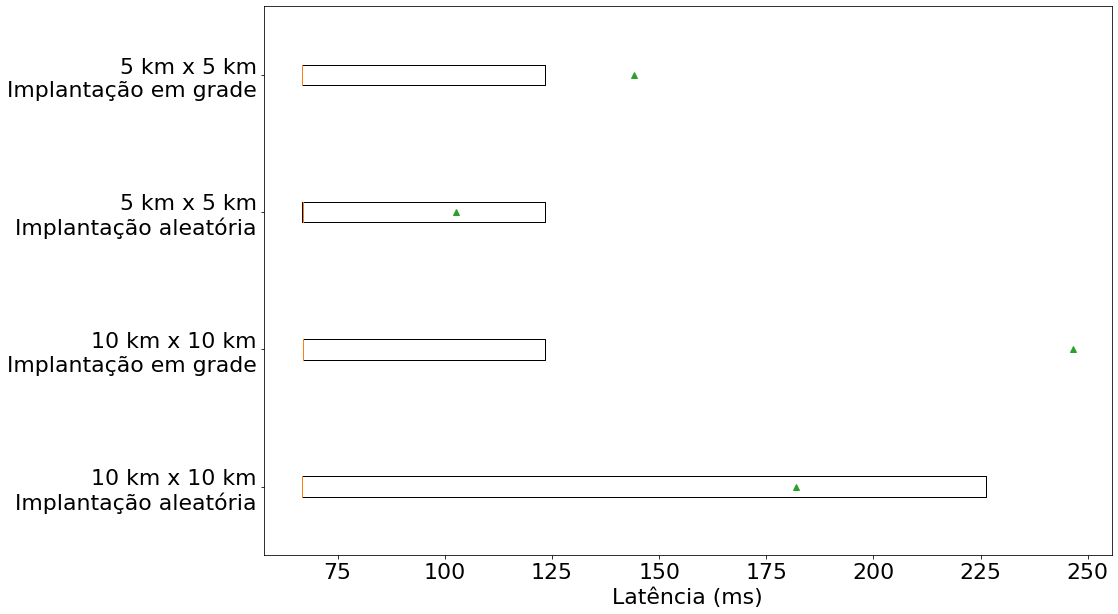

CPU times: user 1.25 s, sys: 240 ms, total: 1.49 s
Wall time: 1.18 s


In [378]:
%%time

subtitles = {
    'A3F1D1T1S1' : '5 km x 5 km\nImplantação em grade',
    'A3F1D2T1S1' : '5 km x 5 km\nImplantação aleatória',
    'A4F1D1T1S1' : '10 km x 10 km\nImplantação em grade',
    'A4F1D2T1S1' : '10 km x 10 km\nImplantação aleatória',
    }

log_path_list_extra = ['scenario6/derA3F1D1T1S1', 'scenario6/derA3F1D2T1S1',
                      'scenario6/derA4F1D1T1S1', 'scenario6/derA4F1D2T1S1']
log_path_list_extra.reverse()

latency = pd.DataFrame()
for num_log_path, log_path in enumerate(log_path_list_extra):
    scenario_config = log_path[-10:]
    scenario_number = int(log_path[8])
    
    df = log_to_frame(log_path)
    df['latency'] = df['latency'] * 1000
    subtitle = subtitles[scenario_config]
    latency[subtitle] = df['latency']
    
    print(df['latency'].dropna().mean())
    
fig, ax = plt.subplots(figsize=(16,9))

bp = []
for pos, col in enumerate(latency):
    bp.append(ax.boxplot(latency[col].dropna(), positions=[pos], 
                         showmeans=True, vert=False, showfliers=False, whis=0))
    
ax.set_xlabel('Latência (ms)')
# ax.set_ylabel('Configurações')
ax.set_yticklabels(latency.columns.values, rotation='horizontal')
#ax.set_xlim(0, 450)

plt.tight_layout()
plt.savefig('lat6.jpg')
plt.show()

5 km x 5 km, Implantação em grade
20:36:00 - 265569s
Média: 126.54
Mediana: 66.8217

5 km x 5 km, Implantação aleatória
20:36:00 - 0s
Média: 94.02
Mediana: 66.8231

10 km x 10 km, Implantação em grade
20:36:00 - 0s
Média: 246.58
Mediana: 66.8255

10 km x 10 km, Implantação aleatória
20:36:01 - 0s
Média: 181.92
Mediana: 66.8233



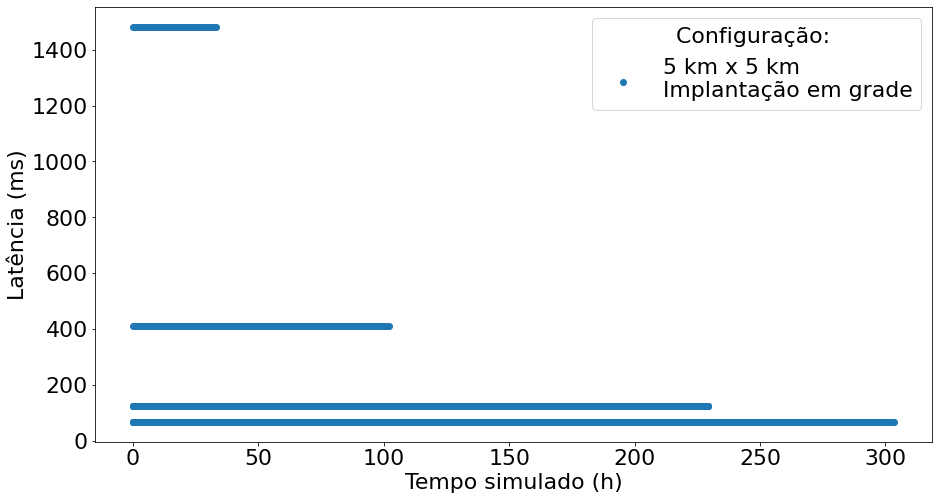

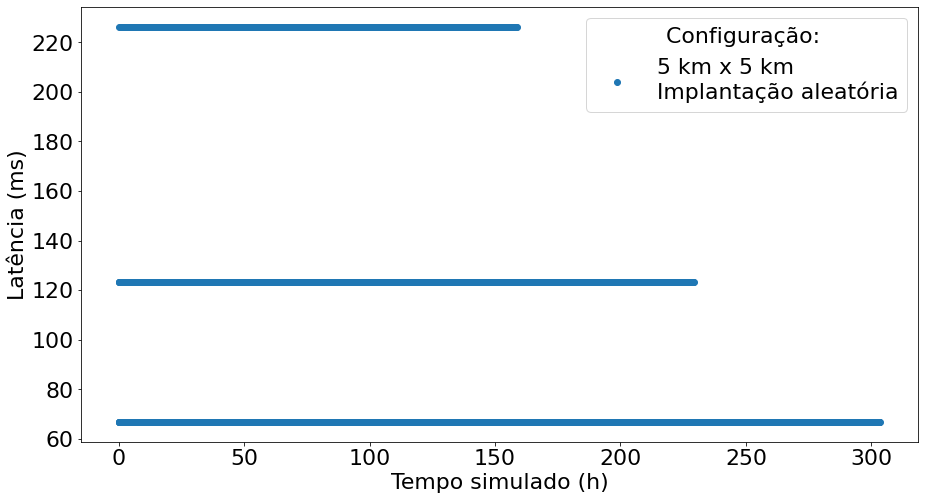

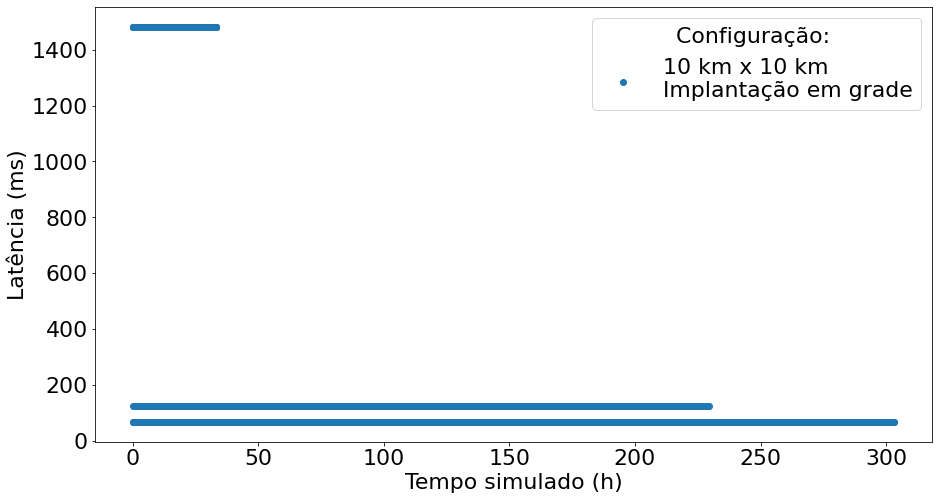

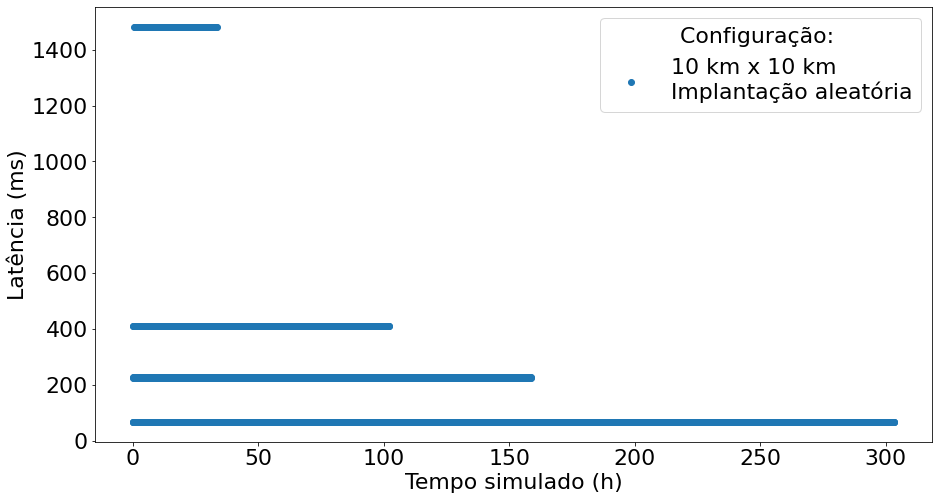

CPU times: user 1.57 s, sys: 32.1 ms, total: 1.6 s
Wall time: 1.63 s


In [413]:
%%time

subtitles = {
    'A3F1D1T1S1' : '5 km x 5 km\nImplantação em grade',
    'A3F1D2T1S1' : '5 km x 5 km\nImplantação aleatória',
    'A4F1D1T1S1' : '10 km x 10 km\nImplantação em grade',
    'A4F1D2T1S1' : '10 km x 10 km\nImplantação aleatória',
    }

log_path_list_extra = ['scenario6/derA3F1D1T1S1', 'scenario6/derA3F1D2T1S1',
                      'scenario6/derA4F1D1T1S1', 'scenario6/derA4F1D2T1S1']

latency = pd.DataFrame()
for num_log_path, log_path in enumerate(log_path_list_extra):
    scenario_config = log_path[-10:]
    scenario_number = int(log_path[8])
    
    df = log_to_frame(log_path)
    df['latency'] = df['latency'] * 1000
    df['cum_avg_lat'] = df['latency'].expanding().mean()
    
    x = df['time'] / 3600
    y = df['latency']

    subtitle = subtitles[scenario_config]

    plt.figure(figsize=(15,8))
    plt.scatter(x, y, label=subtitle)
    plt.legend(title="Configuração: ", loc='upper right',fancybox=True)
    
    print(subtitle.replace('\n', ', '))
    
    duration = (datetime.now() - now).total_seconds()
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(f'{current_time} - {int(duration)}s')
    
    print('Média: {:.2f}'.format(df['latency'].mean()))
    print('Mediana: {:.4f}'.format(df['latency'].median()))
    print()
    
    plt.xlabel("Tempo simulado (h)")
    plt.ylabel("Latência (ms)")
#plt.xlim(0,6)
plt.show()

5 km x 5 km, Implantação em grade
20:36:34 - 32s
Min: 66.8207
Max: 1482.7724
Média: 126.54
Mediana: 66.8217

5 km x 5 km, Implantação aleatória
20:36:34 - 0s
Min: 66.8197
Max: 226.3179
Média: 94.02
Mediana: 66.8231

10 km x 10 km, Implantação em grade
20:36:34 - 0s
Min: 66.8254
Max: 1482.7803
Média: 246.58
Mediana: 66.8255

10 km x 10 km, Implantação aleatória
20:36:34 - 0s
Min: 66.8210
Max: 1482.7712
Média: 181.92
Mediana: 66.8233

CPU times: user 1.19 s, sys: 8.03 ms, total: 1.2 s
Wall time: 1.19 s


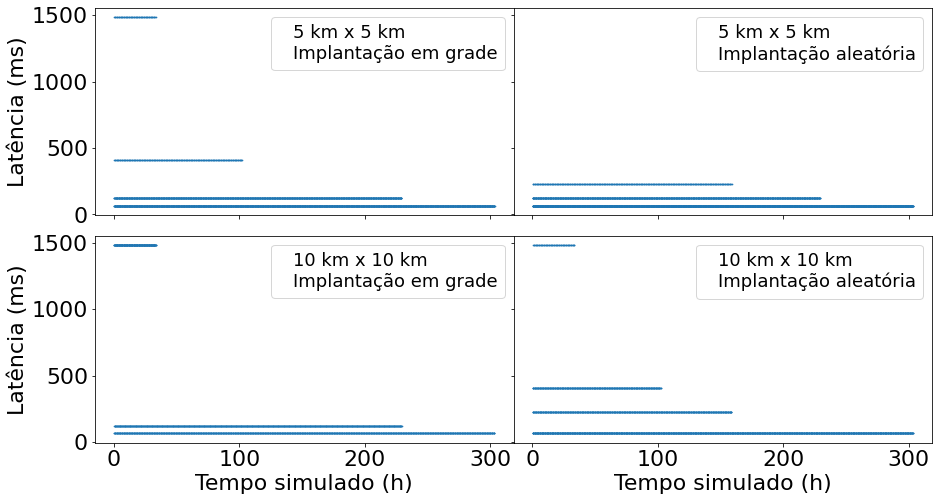

In [414]:
%%time

fig = plt.figure(figsize=(15,8))
gs = fig.add_gridspec(2, 2, hspace=0.1, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')
axes = [ax1, ax2, ax3, ax4]

subtitles = {
    'A3F1D1T1S1' : '5 km x 5 km\nImplantação em grade',
    'A3F1D2T1S1' : '5 km x 5 km\nImplantação aleatória',
    'A4F1D1T1S1' : '10 km x 10 km\nImplantação em grade',
    'A4F1D2T1S1' : '10 km x 10 km\nImplantação aleatória',
    }

log_path_list_extra = ['scenario6/derA3F1D1T1S1', 'scenario6/derA3F1D2T1S1',
                      'scenario6/derA4F1D1T1S1', 'scenario6/derA4F1D2T1S1']

latency = pd.DataFrame()
for num_log_path, log_path in enumerate(log_path_list_extra):
    scenario_config = log_path[-10:]
    scenario_number = int(log_path[8])
    
    df = log_to_frame(log_path)
    df['latency'] = df['latency'] * 1000
    df['cum_avg_lat'] = df['latency'].expanding().mean()
    
    x = df['time'] / 3600
    y = df['latency']

    subtitle = subtitles[scenario_config]
    
    axes[num_log_path].scatter(x, y, s=0.5, label=subtitle)
    axes[num_log_path].legend(loc='upper right', fontsize=18, fancybox=True,
                              markerscale=0, handlelength=0)
    
    print(subtitle.replace('\n', ', '))
    
    duration = (datetime.now() - now).total_seconds()
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(f'{current_time} - {int(duration)}s')
    
    print('Min: {:.4f}'.format(df['latency'].min()))
    print('Max: {:.4f}'.format(df['latency'].max()))
    print('Média: {:.2f}'.format(df['latency'].mean()))
    print('Mediana: {:.4f}'.format(df['latency'].median()))
    print()

    
fig.suptitle('')
ax3.set_xlabel('Tempo simulado (h)')
ax4.set_xlabel('Tempo simulado (h)')

ax1.set_ylabel('Latência (ms)')
ax3.set_ylabel('Latência (ms)')

for ax in fig.get_axes():
    #ax.set_ylim(-5, 105)
    ax.label_outer()
    
plt.savefig('latencia.jpg')

5 km x 5 km, Implantação em grade
22:41:55 - 137s
Média: 126.54
Mediana: 66.8217

5 km x 5 km, Implantação aleatória
22:41:56 - 0s
Média: 94.02
Mediana: 66.8231

10 km x 10 km, Implantação em grade
22:41:56 - 0s
Média: 246.58
Mediana: 66.8255

10 km x 10 km, Implantação aleatória
22:41:56 - 0s
Média: 181.92
Mediana: 66.8233



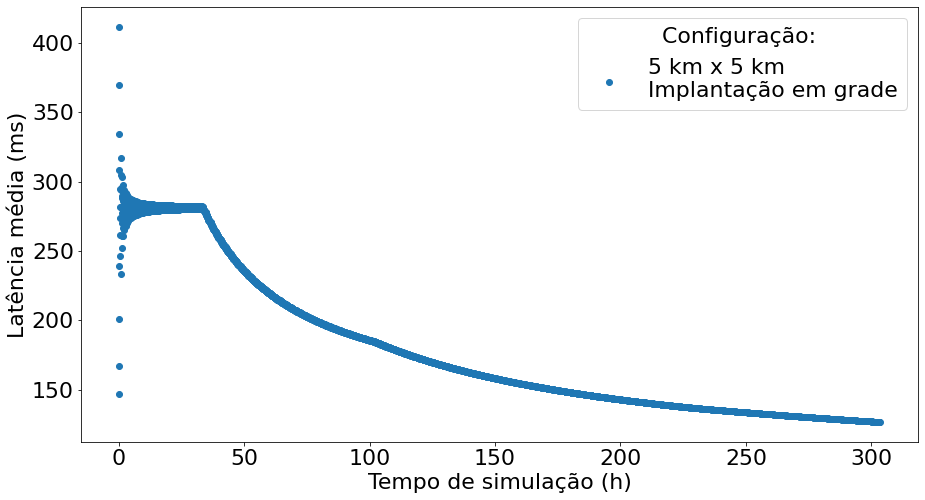

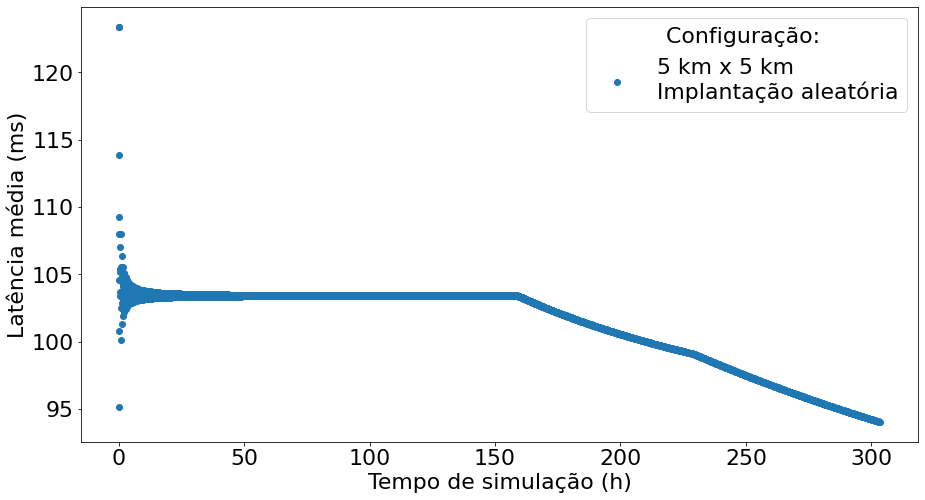

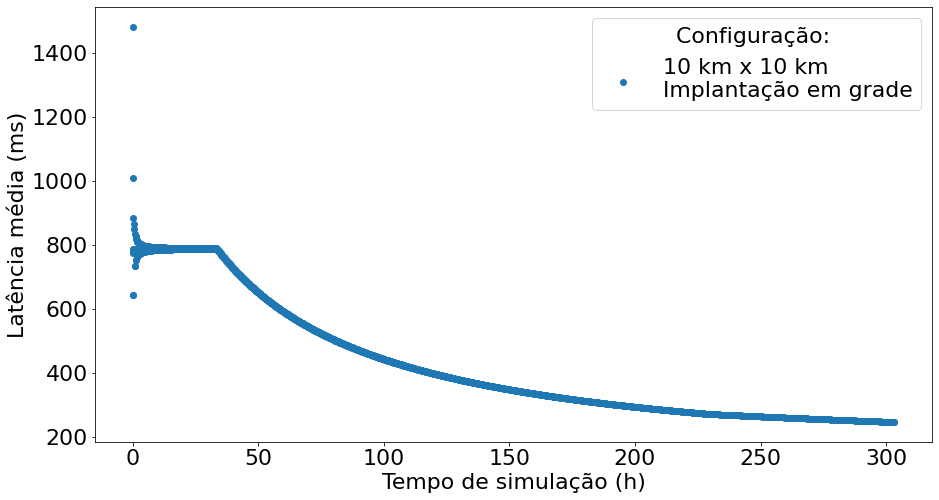

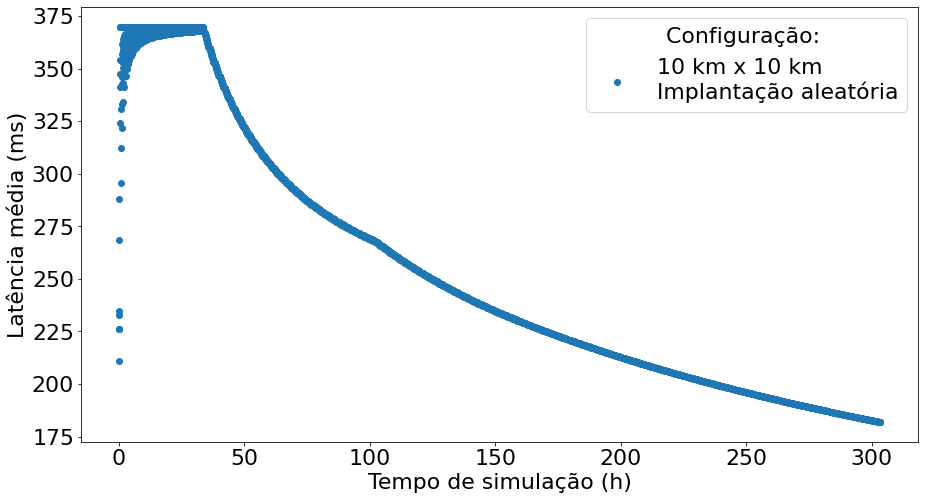

CPU times: user 1.77 s, sys: 12.1 ms, total: 1.78 s
Wall time: 1.77 s


In [356]:
%%time

subtitles = {
    'A3F1D1T1S1' : '5 km x 5 km\nImplantação em grade',
    'A3F1D2T1S1' : '5 km x 5 km\nImplantação aleatória',
    'A4F1D1T1S1' : '10 km x 10 km\nImplantação em grade',
    'A4F1D2T1S1' : '10 km x 10 km\nImplantação aleatória',
    }

log_path_list_extra = ['scenario6/derA3F1D1T1S1', 'scenario6/derA3F1D2T1S1',
                      'scenario6/derA4F1D1T1S1', 'scenario6/derA4F1D2T1S1']

latency = pd.DataFrame()
for num_log_path, log_path in enumerate(log_path_list_extra):
    scenario_config = log_path[-10:]
    scenario_number = int(log_path[8])
    
    df = log_to_frame(log_path)
    df['latency'] = df['latency'] * 1000
    df['cum_avg_lat'] = df['latency'].expanding().mean()
    
    x = df['time'] / 3600
    y = df['cum_avg_lat']

    subtitle = subtitles[scenario_config]

    plt.figure(figsize=(15,8))
    plt.scatter(x, y, label=subtitle)
    plt.legend(title="Configuração: ", loc='upper right',fancybox=True)
    
    print(subtitle.replace('\n', ', '))
    
    duration = (datetime.now() - now).total_seconds()
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(f'{current_time} - {int(duration)}s')
    
    print('Média: {:.2f}'.format(df['latency'].mean()))
    print('Mediana: {:.4f}'.format(df['latency'].median()))
    print()
    
    plt.xlabel("Tempo de simulação (h)")
    plt.ylabel("Latência média (ms)")
#plt.xlim(0,6)
plt.show()

304.07448521082836
313.7885902803787
66.81605628774986
66.81605567615325


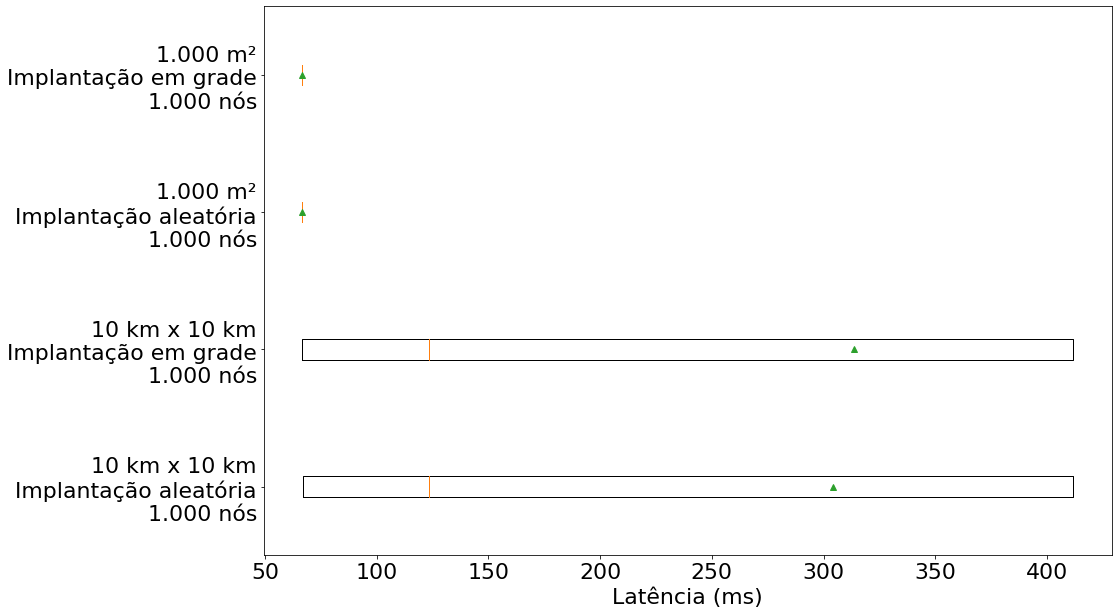

CPU times: user 2min 32s, sys: 420 ms, total: 2min 32s
Wall time: 2min 32s


In [379]:
%%time

subtitles = {
    'A1F1D1T1S4' : '1.000 m²\nImplantação em grade\n1.000 nós',
    'A1F1D2T1S4' : '1.000 m²\nImplantação aleatória\n1.000 nós',
    'A4F1D1T1S4' : '10 km x 10 km\nImplantação em grade\n1.000 nós', 
    'A4F1D2T1S4' : '10 km x 10 km\nImplantação aleatória\n1.000 nós'
    }

log_path_list_extra = ['scenario7/derA1F1D1T1S4', 
                       'scenario7/derA1F1D2T1S4',
                       'scenario7/derA4F1D1T1S4', 
                       'scenario7/derA4F1D2T1S4']
log_path_list_extra.reverse()

latency = pd.DataFrame()
for num_log_path, log_path in enumerate(log_path_list_extra):
    scenario_config = log_path[-10:]
    scenario_number = int(log_path[8])
    
    df = log_to_frame(log_path)
    df['latency'] = df['latency'] * 1000
    subtitle = subtitles[scenario_config]
    latency[subtitle] = df['latency']
    
    print(df['latency'].mean())
    
fig, ax = plt.subplots(figsize=(16,9))

bp = []
for pos, col in enumerate(latency):
    bp.append(ax.boxplot(latency[col].dropna(), positions=[pos], 
                         showmeans=True, vert=False, showfliers=False, whis=0))
    
ax.set_xlabel('Latência (ms)')
#ax.set_ylabel('Configurações')
ax.set_yticklabels(latency.columns.values, rotation='horizontal')
#ax.set_xlim(0, 450)

plt.tight_layout()
plt.savefig('lat7.jpg')
plt.show()

19:26:49
Cenário 6 - A3F1D1T1S1 - DER = 1.0


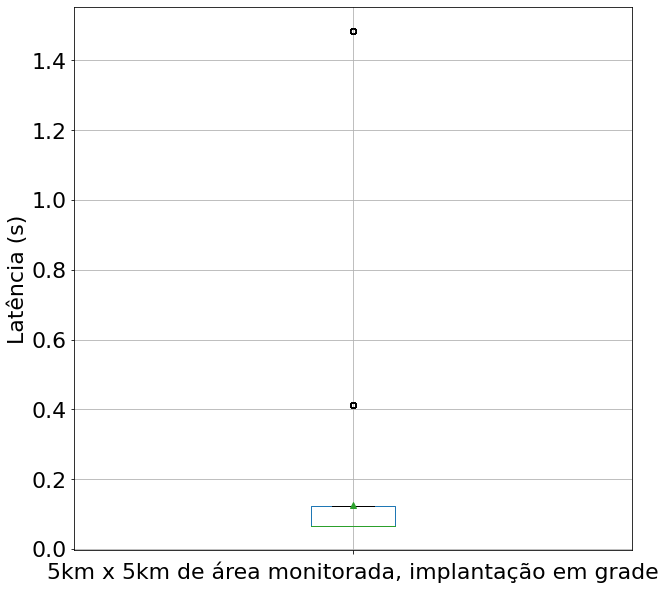

19:26:49 - 0s
Cenário 6 - A3F1D2T1S1 - DER = 1.0


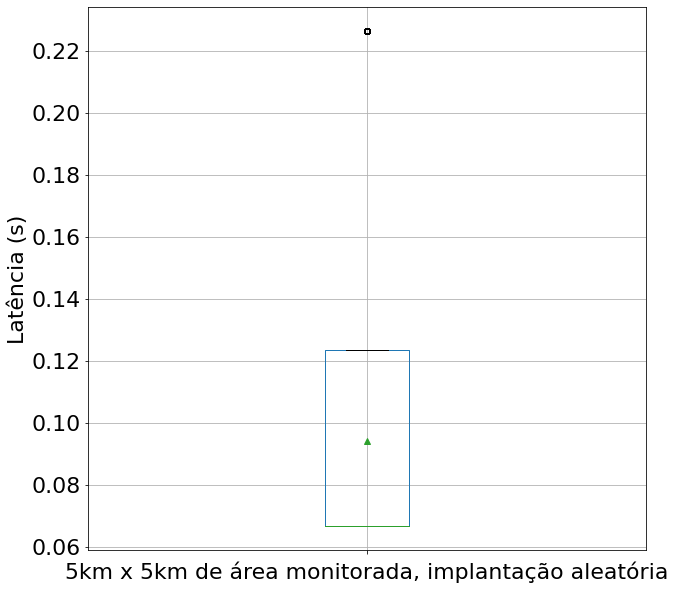

19:26:50 - 0s
Cenário 6 - A4F1D1T1S1 - DER = 0.9728415079043372


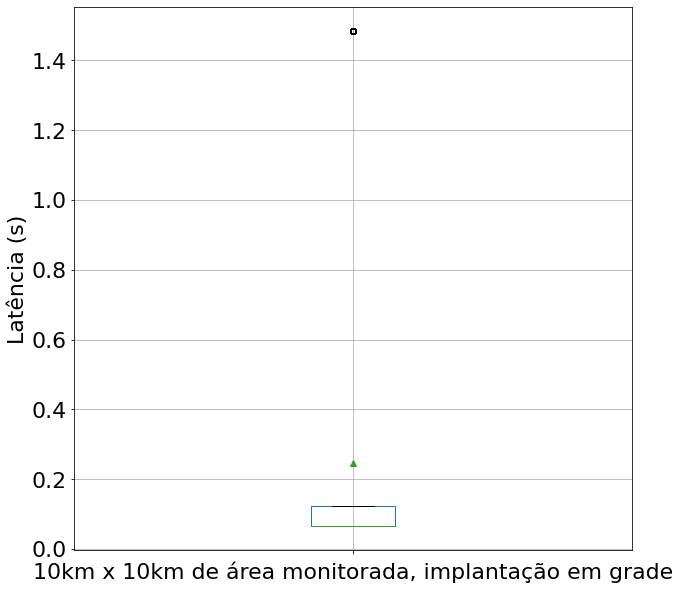

19:26:50 - 0s
Cenário 6 - A4F1D2T1S1 - DER = 0.9776741086304566


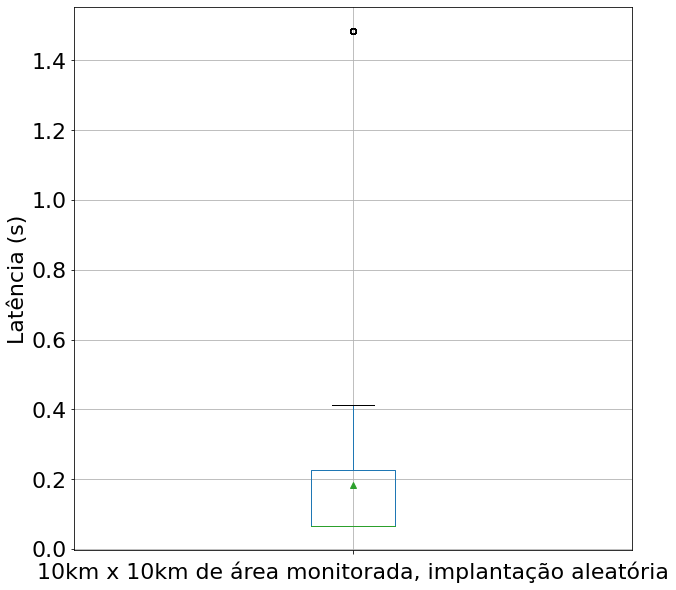

19:26:51 - 0s
CPU times: user 2.04 s, sys: 23.2 ms, total: 2.07 s
Wall time: 2.05 s


In [26]:
%%time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f"{current_time}")

log_path_list_extra = ['scenario6/derA3F1D1T1S1', 'scenario6/derA3F1D2T1S1',
                      'scenario6/derA4F1D1T1S1', 'scenario6/derA4F1D2T1S1']

#log_path_list_extra = ['scenario7/derA1F1D1T1S4', 'scenario7/derA1F1D2T1S4']

for log_path in log_path_list_extra:
    scenario_config = log_path[-10:]
    scenario_number = log_path[8]
    
    now = datetime.now()
    
    df = log_to_frame(log_path)
    der = (~df['receiver'].isna()).sum() / df['sender'].count()
    print(f'Cenário {scenario_number} - {scenario_config} - DER = {der}')
    
    df[['latency']].rename(columns={'latency' : ''}).boxplot(figsize=(10,10), showmeans=True)
    subtitle = subtitles[scenario_config]
    #title = 'Latência para o cenário: \n {} \n'.format(subtitle)
    plt.title('')
    plt.xlabel(subtitle)
    plt.ylabel('Latência (s)')
    plt.savefig('Latência para o cenário: {} .jpg'.format(scenario_config))
    plt.show()
    
    duration = (datetime.now() - now).total_seconds()
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(f'{current_time} - {int(duration)}s')

19:15:11
Cenário 6 - A3F1D1T1S1 - DER = 1.0


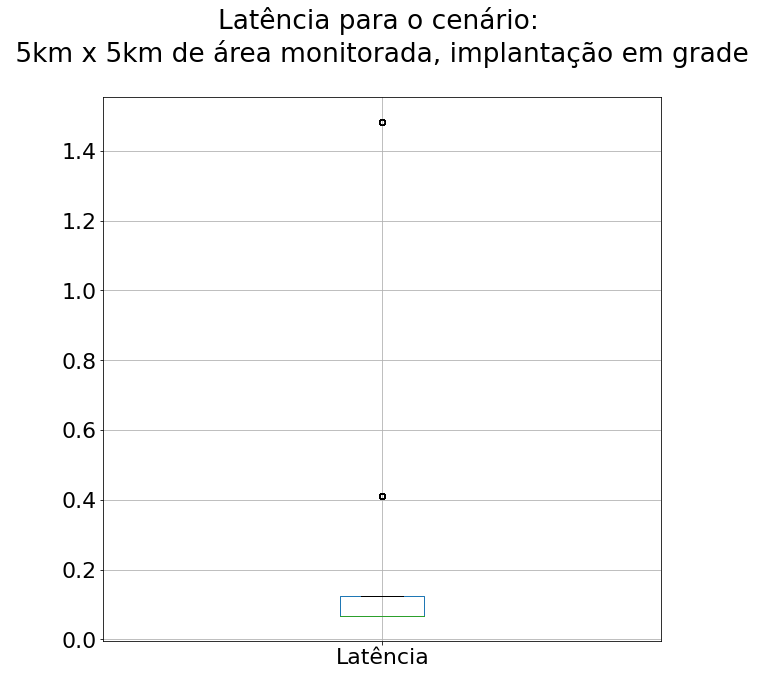

19:15:12 - 0s
Cenário 6 - A3F1D2T1S1 - DER = 1.0


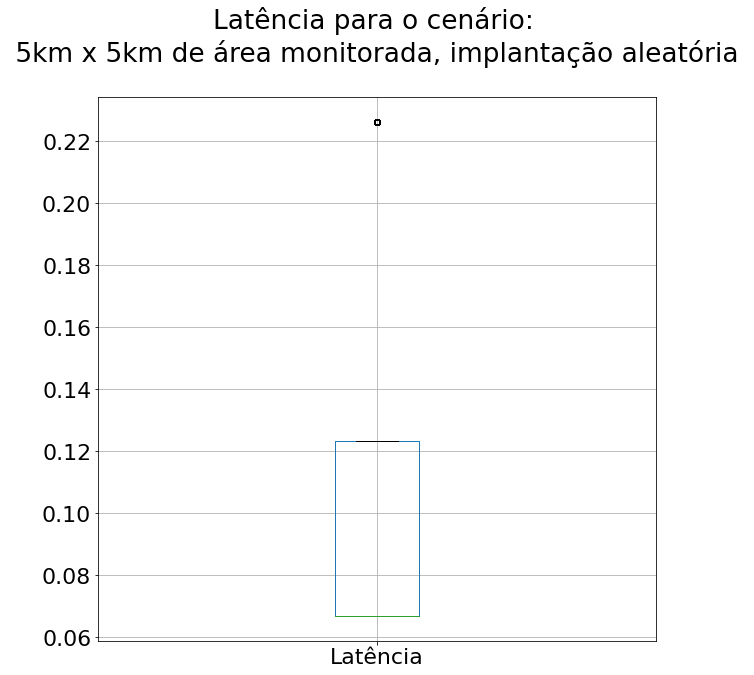

19:15:12 - 0s
Cenário 6 - A4F1D1T1S1 - DER = 0.9728415079043372


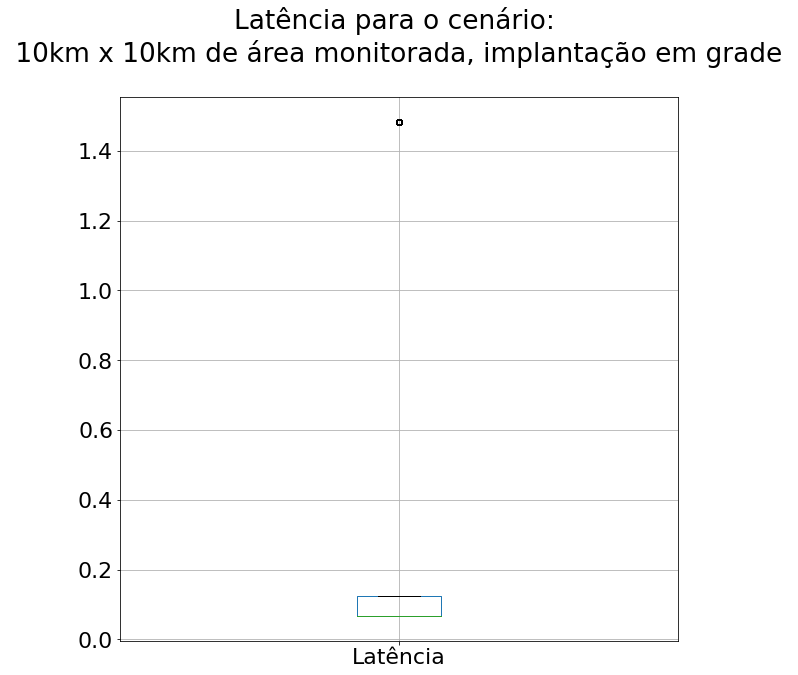

19:15:13 - 0s
Cenário 6 - A4F1D2T1S1 - DER = 0.9776741086304566


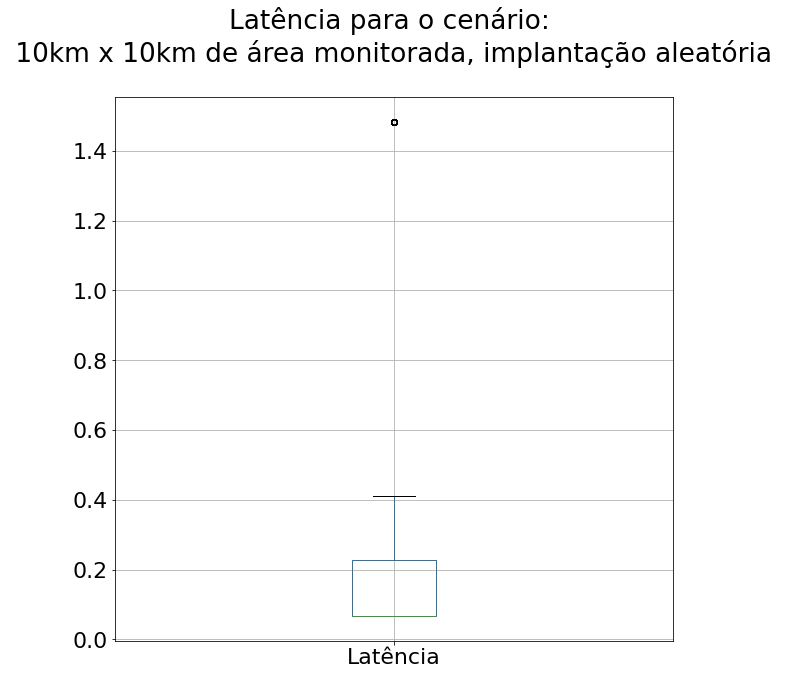

19:15:13 - 0s
CPU times: user 1.97 s, sys: 12.1 ms, total: 1.98 s
Wall time: 1.97 s


In [19]:
%%time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f"{current_time}")

log_path_list_extra = ['scenario6/derA3F1D1T1S1', 'scenario6/derA3F1D2T1S1',
                      'scenario6/derA4F1D1T1S1', 'scenario6/derA4F1D2T1S1']

#log_path_list_extra = ['scenario7/derA1F1D1T1S4', 'scenario7/derA1F1D2T1S4']

for log_path in log_path_list_extra:
    scenario_config = log_path[-10:]
    scenario_number = log_path[8]
    
    now = datetime.now()
    
    df = log_to_frame(log_path)
    der = (~df['receiver'].isna()).sum() / df['sender'].count()
    print(f'Cenário {scenario_number} - {scenario_config} - DER = {der}')
    
    df[['latency']].rename(columns={'latency' : 'Latência'}).boxplot(figsize=(10,10))
    subtitle = subtitles[scenario_config]
    title = 'Latência para o cenário: \n {} \n'.format(subtitle)
    plt.title(title)
    plt.ylabel('')
    plt.savefig('Latência para o cenário: {} .jpg'.format(scenario_config))
    plt.show()
    
    duration = (datetime.now() - now).total_seconds()
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(f'{current_time} - {int(duration)}s')

In [14]:
def DER_curve(df):
    
    binarize = lambda x: 0 if pd.isna(x) else 1
    num = df['receiver'].apply(binarize).cumsum()
    dem = df['sender'].apply(binarize).cumsum()
    
    DER = pd.DataFrame()
    DER['time'] = df['time'] / 60 / 60
    DER['packet'] = df['packet']
    DER['DER'] = (num / dem) *100
    return DER


18:49:05
Cenário 1 - A1F1D1T1S1 - DER = 1.0
18:49:05 - 0s
Cenário 1 - A2F1D1T1S1 - DER = 0.9890467488256716
18:49:45 - 39s
Cenário 2 - A1F2D1T1S1 - DER = 1.0
18:49:45 - 0s
Cenário 2 - A1F3D1T1S1 - DER = 1.0
18:49:46 - 0s
Cenário 3 - A1F1D2T1S1 - DER = 1.0
18:49:46 - 0s
Cenário 4 - A1F1D1T2S1 - DER = 1.0
18:49:46 - 0s
Cenário 4 - A1F1D1T3S1 - DER = 1.0
18:49:46 - 0s
Cenário 5 - A1F1D1T1S2 - DER = 1.0
18:49:48 - 1s
Cenário 5 - A1F1D1T1S3 - DER = 1.0
18:49:51 - 2s


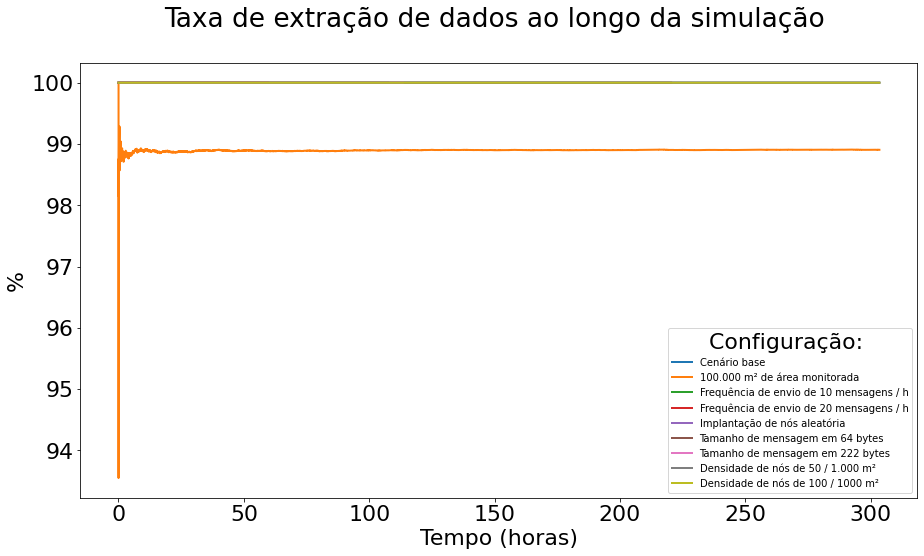

CPU times: user 45.8 s, sys: 75.9 ms, total: 45.9 s
Wall time: 45.9 s


In [412]:
%%time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f"{current_time}")

plt.figure(figsize=(15,8))

#log_path_list_extra = log_path_list + ['scenario6/derA3F1D1T1S1', 'scenario6/derA3F1D2T1S1']

#log_path_list_extra = ['scenario7/derA1F1D1T1S4', 'scenario7/derA1F1D2T1S4']

for num_log_path, log_path in enumerate(log_path_list):
    scenario_config = log_path[-10:]
    scenario_number = int(log_path[8])
    
    if((scenario_config == 'A1F1D1T1S1') & (num_log_path > 0)):
        continue
    
    df = log_to_frame(log_path)
    
    der = (~df['receiver'].isna()).sum() / df['sender'].count()
    print(f'Cenário {scenario_number} - {scenario_config} - DER = {der}')
    
    der_curve = DER_curve(df)
    
    x = der_curve['time']
    y = der_curve['DER']

    subtitle = subtitles[scenario_config]

    plt.plot(x, y, linewidth=2, label=subtitle)
    plt.legend(title="Configuração: ", loc='lower right', fontsize=10, fancybox=True)
    
    
    duration = (datetime.now() - now).total_seconds()
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(f'{current_time} - {int(duration)}s')
    
plt.xlabel("Tempo (horas)")
plt.ylabel("%")
plt.title(f'Taxa de extração de dados ao longo da simulação \n')
#plt.xlim(0,6)
plt.show()

In [35]:
df['time'].max() / 60 / 60

303.2371360418211

In [14]:
def depletion(log_path):
    
    time = []
    node = []
    with open(f'../log/{log_path}.txt') as file:
        for line in file:
            if(line[0] == '-'):
                #print(line)
                splitted = line.split(' ')

                time.append(splitted[0][1:-1])
                node.append(splitted[1])

        deplet = pd.DataFrame(list(zip(time, node)), columns = ['time', 'node'])
        deplet.time = deplet.time.astype('float') / 3600
        deplet.node = deplet.node.astype('int')
        deplet = deplet.sort_values(by='time')
        
    return deplet

In [15]:
log_path_list_extra = ['scenario6/derA3F1D1T1S1', 'scenario6/derA3F1D2T1S1',
                      'scenario6/derA4F1D1T1S1', 'scenario6/derA4F1D2T1S1']
for num_log_path, log_path in enumerate(log_path_list_extra):
    
    deplet = depletion(log_path)
    print(deplet)

Empty DataFrame
Columns: [time, node]
Index: []
Empty DataFrame
Columns: [time, node]
Index: []
         time  node
0   33.088333     3
1   33.122500     8
2   33.202500     0
3   33.209444     6
4   33.237500     1
5  229.155278     7
6  229.430833     2
7  303.097222     4
8  303.188889     5
         time  node
0   33.088333     3
1   33.431111     2
2  102.155278     7
3  102.202222     0
4  158.596111     4
5  158.622222     8
6  303.188889     5
7  303.208333     6
8  303.236111     1


In [16]:
from adjustText import adjust_text

22:43:16
Cenário 6 - A3F1D1T1S1 - DER = 1.0
22:43:16 - 0s
Cenário 6 - A3F1D2T1S1 - DER = 1.0
22:43:16 - 0s
Cenário 6 - A4F1D1T1S1 - DER = 0.9728415079043372
22:43:16 - 0s
Cenário 6 - A4F1D2T1S1 - DER = 0.9776741086304566
22:43:17 - 0s


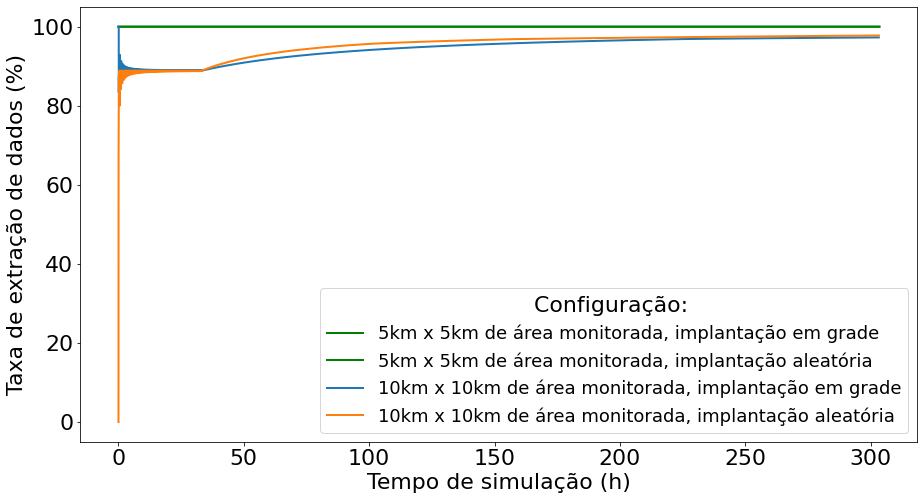

CPU times: user 1.14 s, sys: 20.1 ms, total: 1.16 s
Wall time: 1.15 s


In [37]:
%%time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f"{current_time}")

plt.figure(figsize=(15,8))

log_path_list_extra = ['scenario6/derA3F1D1T1S1', 'scenario6/derA3F1D2T1S1',
                      'scenario6/derA4F1D1T1S1', 'scenario6/derA4F1D2T1S1']

for num_log_path, log_path in enumerate(log_path_list_extra):
    scenario_config = log_path[-10:]
    scenario_number = int(log_path[8])
    
    if((scenario_config == 'A1F1D1T1S1') & (num_log_path > 0)):
        continue
    
    df = log_to_frame(log_path)
    
    der = (~df['receiver'].isna()).sum() / df['sender'].count()
    print(f'Cenário {scenario_number} - {scenario_config} - DER = {der}')

    subtitle = subtitles[scenario_config]
    
    der_curve = DER_curve(df)

    x = der_curve['time']
    y = der_curve['DER']
    if(der == 1):
        plt.plot(x, y, linewidth=2, label=subtitle, color = 'green')
    else:
        plt.plot(x, y, linewidth=2, label=subtitle)

    
    plt.legend(title="Configuração: ", loc='lower right', fontsize=18, fancybox=True)
    
    
    duration = (datetime.now() - now).total_seconds()
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(f'{current_time} - {int(duration)}s')
    
plt.xlabel("Tempo de simulação (h)")
plt.ylabel("Taxa de extração de dados (%)")
#plt.title(f'Taxa de extração de dados ao longo da simulação \n')
#plt.xlim(0,6)
#plt.ylim(75,101)
plt.savefig('S1.jpg')
plt.show()

0        True
1        True
2        True
3        True
4        True
        ...  
2996    False
2997    False
2998    False
2999    False
3000    False
Name: time, Length: 3001, dtype: bool

20:38:29
Cenário 6 - A3F1D1T1S1 - DER = 1.0
20:38:30 - 0s
Cenário 6 - A3F1D2T1S1 - DER = 1.0
20:38:30 - 0s
Cenário 6 - A4F1D1T1S1 - DER = 0.9728415079043372
20:38:30 - 0s
Cenário 6 - A4F1D2T1S1 - DER = 0.9776741086304566
20:38:30 - 0s
CPU times: user 1.19 s, sys: 20.1 ms, total: 1.21 s
Wall time: 1.19 s


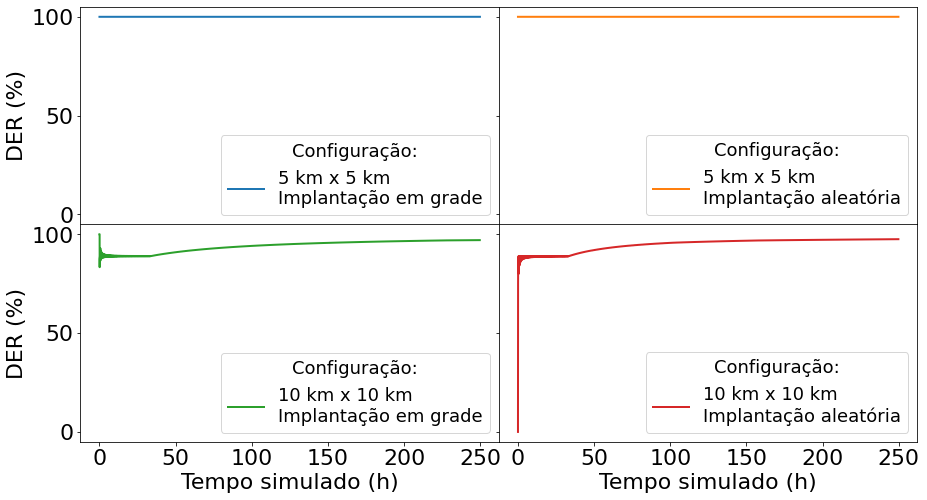

In [415]:
%%time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f"{current_time}")


fig = plt.figure(figsize=(15,8))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')
axes = [ax1, ax2, ax3, ax4]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

log_path_list_extra = ['scenario6/derA3F1D1T1S1', 'scenario6/derA3F1D2T1S1',
                      'scenario6/derA4F1D1T1S1', 'scenario6/derA4F1D2T1S1']

subtitles = {
    'A3F1D1T1S1' : '5 km x 5 km\nImplantação em grade',
    'A3F1D2T1S1' : '5 km x 5 km\nImplantação aleatória',
    'A4F1D1T1S1' : '10 km x 10 km\nImplantação em grade',
    'A4F1D2T1S1' : '10 km x 10 km\nImplantação aleatória',
    }

for num_log_path, log_path in enumerate(log_path_list_extra):
    scenario_config = log_path[-10:]
    scenario_number = int(log_path[8])
    
    if((scenario_config == 'A1F1D1T1S1') & (num_log_path > 0)):
        continue
    
    df = log_to_frame(log_path)
    
    der = (~df['receiver'].isna()).sum() / df['sender'].count()
    print(f'Cenário {scenario_number} - {scenario_config} - DER = {der}')

    subtitle = subtitles[scenario_config]
    
    der_curve = DER_curve(df)

    x = der_curve['time']
    y = der_curve['DER']
    
    # Right limit x-axis 
    xlim = 250
    is_in_xlim = x.apply(lambda row: row < xlim)
    xlim_idx = x.where(is_in_xlim).last_valid_index()
    x = x[:xlim_idx]
    y = y[:xlim_idx]
    
    axes[num_log_path].plot(x, y, linewidth=2, label=subtitle, color = colors[num_log_path])
    axes[num_log_path].legend(title='Configuração:', title_fontsize=18, 
                              loc='lower right', fontsize=18, fancybox=True)
    
    
    duration = (datetime.now() - now).total_seconds()
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(f'{current_time} - {int(duration)}s')

fig.suptitle('')
ax3.set_xlabel('Tempo simulado (h)')
ax4.set_xlabel('Tempo simulado (h)')

ax1.set_ylabel('DER (%)')
ax3.set_ylabel('DER (%)')

for ax in fig.get_axes():
    ax.set_ylim(-5, 105)
    ax.label_outer()
    
plt.savefig('S1.jpg')

18:30:14
Cenário 6 - A3F1D1T1S1 - DER = 1.0
18:30:15 - 0s
Cenário 6 - A3F1D2T1S1 - DER = 1.0
18:30:15 - 0s
Cenário 6 - A4F1D1T1S1 - DER = 0.9728415079043372
18:30:15 - 0s
Cenário 6 - A4F1D2T1S1 - DER = 0.9776741086304566
18:30:15 - 0s


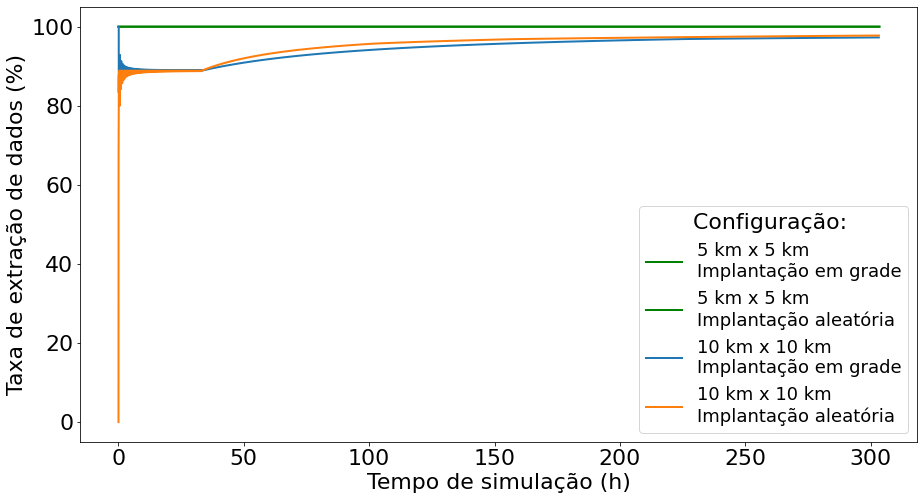

CPU times: user 1.24 s, sys: 8.12 ms, total: 1.25 s
Wall time: 1.23 s


In [400]:
%%time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f"{current_time}")

plt.figure(figsize=(15,8))

log_path_list_extra = ['scenario6/derA3F1D1T1S1', 'scenario6/derA3F1D2T1S1',
                      'scenario6/derA4F1D1T1S1', 'scenario6/derA4F1D2T1S1']

for num_log_path, log_path in enumerate(log_path_list_extra):
    scenario_config = log_path[-10:]
    scenario_number = int(log_path[8])
    
    if((scenario_config == 'A1F1D1T1S1') & (num_log_path > 0)):
        continue
    
    df = log_to_frame(log_path)
    
    der = (~df['receiver'].isna()).sum() / df['sender'].count()
    print(f'Cenário {scenario_number} - {scenario_config} - DER = {der}')

    subtitle = subtitles[scenario_config]
    
    der_curve = DER_curve(df)

    x = der_curve['time']
    y = der_curve['DER']
    if(der == 1):
        plt.plot(x, y, linewidth=2, label=subtitle, color = 'green')
    else:
        plt.plot(x, y, linewidth=2, label=subtitle)

    
    plt.legend(title="Configuração: ", loc='lower right', fontsize=18, fancybox=True)
    
    
    duration = (datetime.now() - now).total_seconds()
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(f'{current_time} - {int(duration)}s')
    
plt.xlabel("Tempo de simulação (h)")
plt.ylabel("Taxa de extração de dados (%)")
#plt.title(f'Taxa de extração de dados ao longo da simulação \n')
#plt.xlim(0,6)
#plt.ylim(75,101)
plt.savefig('S1.jpg')
plt.show()

15:30:58
Cenário 6 - A3F1D1T1S1 - DER = 1.0
15:30:58 - 0s
1: 33.2025
4: 102.08805555555556
9: 229.12222222222223
7: 229.20916666666668
2: 229.23722222222221
5: 303.09722222222223
8: 303.15555555555557
6: 303.18888888888887
3: 303.43055555555554
Cenário 6 - A3F1D2T1S1 - DER = 1.0
15:30:59 - 0s
Cenário 6 - A4F1D1T1S1 - DER = 0.9728415079043372
15:30:59 - 0s
Cenário 6 - A4F1D2T1S1 - DER = 0.9776741086304566
15:30:59 - 0s


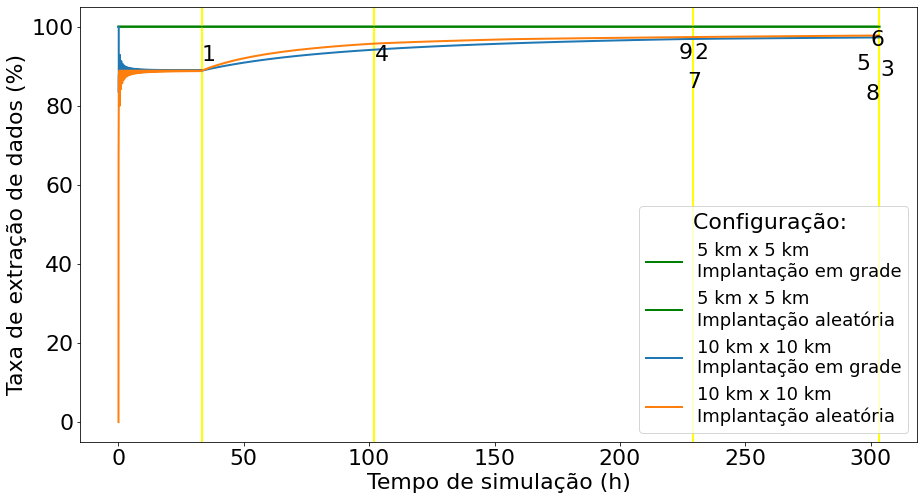

CPU times: user 1.78 s, sys: 441 ms, total: 2.22 s
Wall time: 1.61 s


In [395]:
%%time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f"{current_time}")

plt.figure(figsize=(15,8))

log_path_list_extra = ['scenario6/derA3F1D1T1S1', 'scenario6/derA3F1D2T1S1',
                      'scenario6/derA4F1D1T1S1', 'scenario6/derA4F1D2T1S1']
labels=[]
for num_log_path, log_path in enumerate(log_path_list_extra):
    scenario_config = log_path[-10:]
    scenario_number = int(log_path[8])
    
    if((scenario_config == 'A1F1D1T1S1') & (num_log_path > 0)):
        continue
    
    df = log_to_frame(log_path)
    
    der = (~df['receiver'].isna()).sum() / df['sender'].count()
    print(f'Cenário {scenario_number} - {scenario_config} - DER = {der}')

    subtitle = subtitles[scenario_config]
    
    der_curve = DER_curve(df)

    x = der_curve['time']
    y = der_curve['DER']
    if(der == 1):
        plt.plot(x, y, linewidth=2, label=subtitle, color = 'green')
    else:
        plt.plot(x, y, linewidth=2, label=subtitle)

    
    plt.legend(title="Configuração: ", loc='lower right', fontsize=18, fancybox=True)
    
    
    duration = (datetime.now() - now).total_seconds()
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(f'{current_time} - {int(duration)}s')
    
    if(scenario_config == 'A3F1D1T1S1'):
        deplet = depletion(log_path)
        for i, d in deplet.iterrows():
            node = d['node'] +1
            time = d['time']
            print(f'{int(node)}: {time}')
            plt.axvline(x = time, linewidth=2, color='yellow')
            labels.append(plt.text(time, 90, '%d' %node))
            
adjust_text(labels, autoalign=True)
    
plt.xlabel("Tempo de simulação (h)")
plt.ylabel("Taxa de extração de dados (%)")
#plt.title(f'Taxa de extração de dados ao longo da simulação \n')
#plt.xlim(0,6)
#plt.ylim(75,101)
plt.savefig('S1.jpg')
plt.show()

22:10:26
Cenário 7 - A1F1D1T1S4 - DER = 0.9887069852747137
22:11:03 - 36s
Cenário 7 - A1F1D2T1S4 - DER = 0.9860581490473426
22:11:45 - 41s
Cenário 7 - A4F1D1T1S4 - DER = 0.9640766169627155
22:12:11 - 26s
Cenário 7 - A4F1D2T1S4 - DER = 0.9633302873047678
22:12:40 - 28s


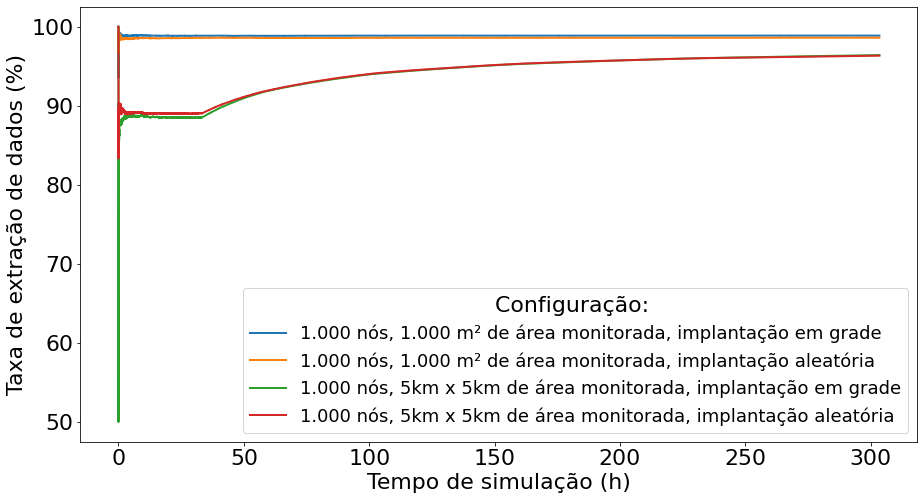

CPU times: user 2min 14s, sys: 82.3 ms, total: 2min 14s
Wall time: 2min 14s


In [36]:
%%time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f"{current_time}")

plt.figure(figsize=(15,8))

log_path_list_extra = ['scenario7/derA1F1D1T1S4', 'scenario7/derA1F1D2T1S4',
                      'scenario7/derA4F1D1T1S4', 'scenario7/derA4F1D2T1S4']

for num_log_path, log_path in enumerate(log_path_list_extra):
    scenario_config = log_path[-10:]
    scenario_number = int(log_path[8])
    
    if((scenario_config == 'A1F1D1T1S1') & (num_log_path > 0)):
        continue
    
    df = log_to_frame(log_path)
    
    der = (~df['receiver'].isna()).sum() / df['sender'].count()
    print(f'Cenário {scenario_number} - {scenario_config} - DER = {der}')
    
    der_curve = DER_curve(df)
    
    x = der_curve['time']
    y = der_curve['DER']

    subtitle = subtitles[scenario_config]

    plt.plot(x, y, linewidth=2, label=subtitle)
    plt.legend(title="Configuração: ", loc='lower right', fontsize=18, fancybox=True)
    
    
    duration = (datetime.now() - now).total_seconds()
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(f'{current_time} - {int(duration)}s')
    
plt.xlabel("Tempo de simulação (h)")
plt.ylabel("Taxa de extração de dados (%)")
#plt.title(f'Taxa de extração de dados ao longo da simulação \n')
#plt.xlim(0,6)
plt.savefig('S4.jpg')
plt.show()

Cenário 7 - A1F1D1T1S4
DER = 0.9887069852747137
21:10:32 - 41s

Cenário 7 - A1F1D2T1S4
DER = 0.9860581490473426
21:11:21 - 48s

Cenário 7 - A4F1D1T1S4
DER = 0.9640766169627155
21:11:51 - 30s

Cenário 7 - A4F1D2T1S4
DER = 0.9633302873047678
21:12:22 - 31s

CPU times: user 2min 31s, sys: 116 ms, total: 2min 31s
Wall time: 2min 31s


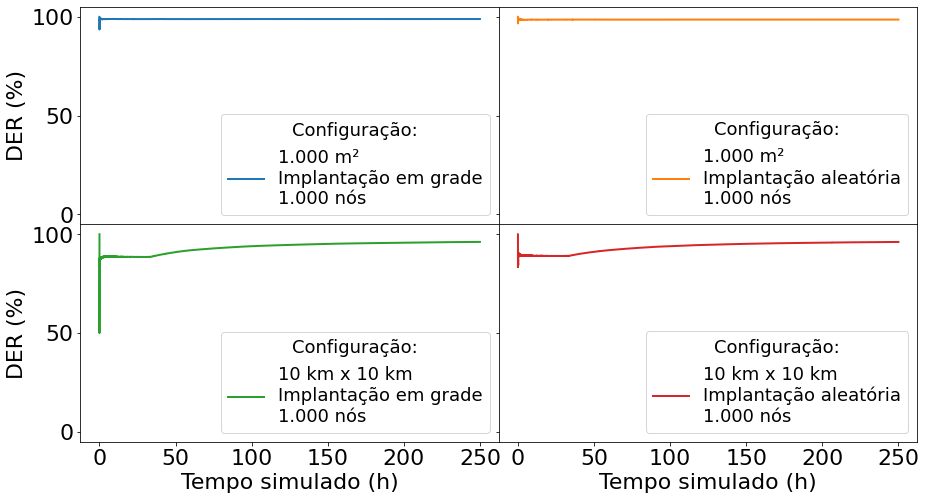

In [16]:
%%time
now = datetime.now()

fig = plt.figure(figsize=(15,8))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')
axes = [ax1, ax2, ax3, ax4]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

subtitles = {
    'A1F1D1T1S4' : '1.000 m²\nImplantação em grade\n1.000 nós',
    'A1F1D2T1S4' : '1.000 m²\nImplantação aleatória\n1.000 nós',
    'A4F1D1T1S4' : '10 km x 10 km\nImplantação em grade\n1.000 nós', 
    'A4F1D2T1S4' : '10 km x 10 km\nImplantação aleatória\n1.000 nós'
    }

log_path_list_extra = ['scenario7/derA1F1D1T1S4', 'scenario7/derA1F1D2T1S4',
                      'scenario7/derA4F1D1T1S4', 'scenario7/derA4F1D2T1S4']

for num_log_path, log_path in enumerate(log_path_list_extra):
    scenario_config = log_path[-10:]
    scenario_number = int(log_path[8])
    
    if((scenario_config == 'A1F1D1T1S1') & (num_log_path > 0)):
        continue
    
    df = log_to_frame(log_path)
    
    der = (~df['receiver'].isna()).sum() / df['sender'].count()
    print(f'Cenário {scenario_number} - {scenario_config}')
    print(f'DER = {der}')
    
    der_curve = DER_curve(df)
    
    x = der_curve['time']
    y = der_curve['DER']
    
    # Right limit x-axis 
    xlim = 250
    is_in_xlim = x.apply(lambda row: row < xlim)
    xlim_idx = x.where(is_in_xlim).last_valid_index()
    x = x[:xlim_idx]
    y = y[:xlim_idx]

    subtitle = subtitles[scenario_config]
    
    axes[num_log_path].plot(x, y, linewidth=2, label=subtitle, color = colors[num_log_path])
    axes[num_log_path].legend(title='Configuração:', title_fontsize=18, 
                              loc='lower right', fontsize=18, fancybox=True)
    
    duration = (datetime.now() - now).total_seconds()
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(f'{current_time} - {int(duration)}s')
    print()

fig.suptitle('')
ax3.set_xlabel('Tempo simulado (h)')
ax4.set_xlabel('Tempo simulado (h)')

ax1.set_ylabel('DER (%)')
ax3.set_ylabel('DER (%)')

for ax in fig.get_axes():
    ax.set_ylim(-5, 105)
    ax.label_outer()
    
plt.savefig('S4.jpg')

17:22:24
17:23:13 - 48s
17:24:03 - 50s
17:24:38 - 34s
17:25:13 - 35s


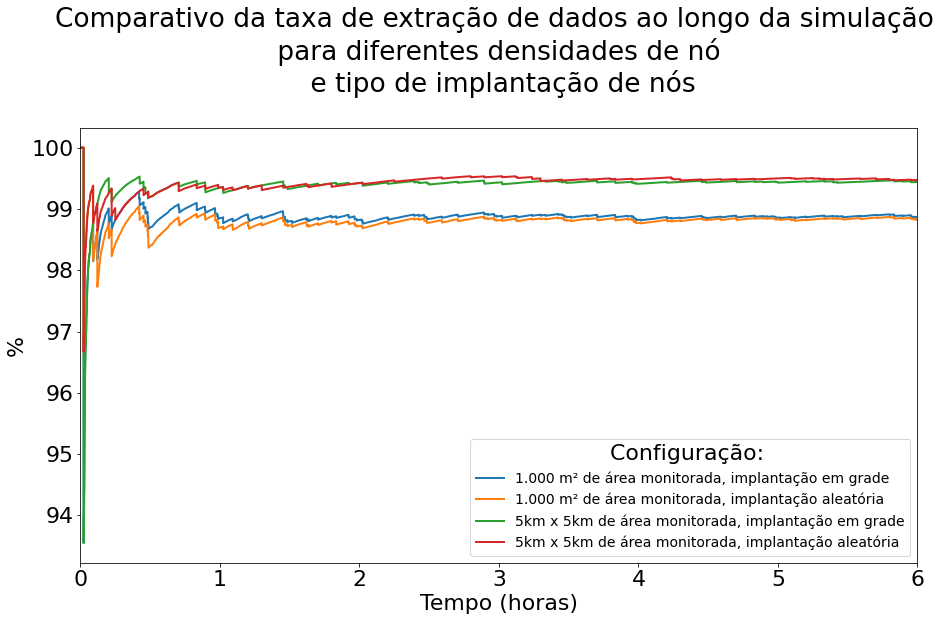

CPU times: user 2min 48s, sys: 63 ms, total: 2min 48s
Wall time: 2min 48s


In [96]:
%%time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f"{current_time}")

plt.figure(figsize=(15,8))

log_path_list_extra = ['scenario7/derA1F1D1T1S4', 'scenario7/derA1F1D2T1S4',
                      'scenario7/derA4F1D1T1S4', 'scenario7/derA4F1D2T1S4']

for num_log_path, log_path in enumerate(log_path_list_extra):
    scenario_config = log_path[-10:]
    scenario_number = int(log_path[8])
    
    if((scenario_config == 'A1F1D1T1S1') & (num_log_path > 0)):
        continue
    
    df = log_to_frame(log_path)
    
    #der = (~df['receiver'].isna()).sum() / df['sender'].count()
    #print(f'Cenário {scenario_number} - {scenario_config} - DER = {der}')
    
    der_curve = DER_curve(df)
    
    x = der_curve['time']
    y = der_curve['DER']

    subtitle = subtitles[scenario_config]

    plt.plot(x, y, linewidth=2, label=subtitle)
    plt.legend(title="Configuração: ", loc='lower right', fontsize=14, fancybox=True)
    
    
    duration = (datetime.now() - now).total_seconds()
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(f'{current_time} - {int(duration)}s')
    
plt.xlabel("Tempo (horas)")
plt.ylabel("%")
plt.title(f'Comparativo da taxa de extração de dados ao longo da simulação \n para diferentes densidades de nó \n e tipo de implantação de nós\n')
plt.xlim(0,6)
plt.show()

----------------------------

In [ ]:
%%time

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f'{current_time}')

log_path = 'scenario2/derA1F3D1T1S1'
df = log_to_frame(log_path)

In [ ]:
# Adding artificial non-received packet for testing purposes 
df_temp = df.copy()
df_temp.loc[len(df_temp)] = {'time' : df.iloc[-1]['time']+1, 
                             'packet' : df.iloc[-1]['packet']+1, 
                             'sender' : df.iloc[-1]['packet'], 
                             'receiver' : None,
                             'latency' : None}
df_temp

----------------------------

In [13]:
df = log_to_frame('scenario7/derA1F1D1T1S4')
df

time  packet  sender receiver   latency
0       6.360852e+00       0     262    999.0  0.066816
1       7.186926e+00       1      64    999.0  0.066816
2       1.190100e+01       2     764    999.0  0.066816
3       1.363026e+01       3      24    999.0  0.066816
4       1.735408e+01       4     798    999.0  0.066816
...              ...     ...     ...      ...       ...
606299  1.092594e+06  606299     402    999.0  0.066816
606300  1.092596e+06  606300     914    999.0  0.066816
606301  1.092596e+06  606301     559    999.0  0.066816
606302  1.092599e+06  606302     675    999.0  0.066816
606303  1.092600e+06  606303     115    999.0  0.066816

[606304 rows x 5 columns]

In [15]:
df.groupby('packet').apply(len).value_counts()

1    606304
dtype: int64